In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from collections import Counter
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import SnowballStemmer

## TODO: usar string.punctuation para limpiar signos de puntuación

In [2]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
%matplotlib inline

In [4]:
datos_originales = pd.read_excel("RESPUESTAS_ENCUESTA.xlsx",sheet_name="DATOS ORIGINALES")
print(datos_originales.columns)

Index(['No.', 'Edad', 'Sexo', 'Nivel Educativo',
       '¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?',
       'Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?',
       '¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?',
       'En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?',
       '¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?'],
      dtype='object')


In [42]:
datos_primera_pregunta = pd.read_excel("RESPUESTAS_ENCUESTA.xlsx",sheet_name="PRIMERA PREGUNTA")
datos_segunda_pregunta = pd.read_excel("RESPUESTAS_ENCUESTA.xlsx",sheet_name="SEGUNDA PREGUNTA")
datos_tercera_pregunta = pd.read_excel("RESPUESTAS_ENCUESTA.xlsx",sheet_name="TERCERA PREGUNTA")
datos_cuarta_pregunta = pd.read_excel("RESPUESTAS_ENCUESTA.xlsx",sheet_name="CUARTA PREGUNTA")
datos_quinta_pregunta = pd.read_excel("RESPUESTAS_ENCUESTA.xlsx",sheet_name="QUINTA PREGUNTA")

### Convertir el nivel educativo a una representación numérica

In [5]:
datos_originales["Nivel Educativo"].unique()

array(['Universitario', 'Maestria', 'Tecnica', 'Diversificado'],
      dtype=object)

In [6]:
nivel_educativo_to_num = {"Diversificado":1,"Tecnica":2,"Universitario":3,"Maestria":4}
num_to_nivel_educativo = {nivel_educativo_to_num[nivel_educativo]:nivel_educativo for nivel_educativo in nivel_educativo_to_num}

In [7]:
datos_originales = datos_originales.replace({"Nivel Educativo":nivel_educativo_to_num})

In [8]:
stopwords = set(["con","como","no","de","y","en","el","a","que","para","la",
                 "mas","un","una","los","puede","o","las","es","al","se","más",
                 "si","del","por"])

In [9]:
def clean_and_pre_process(corpus):
    stemmer = SnowballStemmer("spanish")
    
    corpus = corpus.lower()
    corpus = corpus.translate(str.maketrans('', '', string.punctuation))
    #corpus = " ".join([stemmer.stem(word) for word in corpus.split()])
    
    return corpus

clean_and_pre_process("hola mundo. este , es un. tipo;")

'hola mundo este  es un tipo'

In [10]:
preguntas_abiertas = datos_originales[datos_originales.columns[4:]]

corpus_global = ""

for column in preguntas_abiertas.columns:
    corpus_global = corpus_global + preguntas_abiertas[column].str.cat(sep=" ")
    
corpus_global = clean_and_pre_process(corpus_global)

word_to_int = dict()
int_to_word = dict()
for idx,word in enumerate(corpus_global.split()):
    word_to_int[word] = idx
    int_to_word[idx] = word

In [11]:
def calc_tf_idf(documents_series):
    documents_series =  documents_series.apply(clean_and_pre_process)
    vectorizer = CountVectorizer(min_df=.0025, max_df=.25)
    counts = vectorizer.fit_transform(documents_series)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(counts.toarray()).toarray()
    
    return counts.toarray(),transformer,vectorizer,tfidf

result,transformer,vectorizer,tfidf = calc_tf_idf(datos_originales[datos_originales.columns[4]])



In [43]:
def analisis_categorias(datos,pregunta):
    datos[pregunta].value_counts().plot(kind="barh",legend="")

In [12]:
df  = pd.DataFrame(result,columns=vectorizer.get_feature_names())

df.describe()

,acercarnos,acertado,además,adn,agilizar,ahorrar,ahorro,al,algun,alguna,...,varoas,velocidad,ver,vida,vidas,visión,vista,ya,yo,órganos
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.098039,0.019608,0.019608,...,0.019608,0.019608,0.019608,0.019608,0.039216,0.019608,0.019608,0.058824,0.019608,0.019608
std,0.140028,0.140028,0.140028,0.140028,0.140028,0.140028,0.140028,0.300327,0.140028,0.140028,...,0.140028,0.140028,0.140028,0.140028,0.196039,0.140028,0.140028,0.237635,0.140028,0.140028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
tfidf_df = pd.DataFrame(tfidf,columns=vectorizer.get_feature_names())

tfidf_df.describe()

,acercarnos,acertado,además,adn,agilizar,ahorrar,ahorro,al,algun,alguna,...,varoas,velocidad,ver,vida,vidas,visión,vista,ya,yo,órganos
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,0.004413,0.008627,0.003137,0.006289,0.010548,0.005399,0.005749,0.015245,0.003690,0.010580,...,0.004304,0.003137,0.004304,0.004037,0.022068,0.004358,0.004413,0.015570,0.007324,0.004475
std,0.031514,0.061612,0.022403,0.044916,0.075325,0.038556,0.041053,0.048034,0.026355,0.075558,...,0.030734,0.022403,0.030734,0.028831,0.114033,0.031124,0.031514,0.065191,0.052307,0.031958
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.225058,0.439997,0.159990,0.320763,0.537925,0.275348,0.293180,0.211620,0.188210,0.539591,...,0.219481,0.159990,0.219481,0.205893,0.707107,0.222270,0.225058,0.358326,0.373548,0.228223


In [14]:
def correlacion_edad_palabras(matriz_conteos,vector_edad,conteos_vectorizer,topk = 20):
    edad_y_conteos = np.hstack((np.expand_dims(vector_edad,1),matriz_conteos))
    
    coeficiente_correlacion  = np.corrcoef(edad_y_conteos.T)[0,1:]
    sorted_correlated = np.argsort(coeficiente_correlacion)
    
    positivos_count = 0
    lista_positivos = {}
    
    for index in range(len(sorted_correlated)-1,0,-1):
        pos = sorted_correlated[index]
        if not vectorizer.get_feature_names()[pos] in stopwords:
            #lista_positivos.append((vectorizer.get_feature_names()[pos],coeficiente_correlación[pos]))
            lista_positivos[vectorizer.get_feature_names()[pos]] = coeficiente_correlacion[pos]
            positivos_count += 1
            
            if positivos_count >= topk:
                break
                
                
    negativos_count = 0
    lista_negativos = {}
    
    for index in range(len(sorted_correlated)):
        pos = sorted_correlated[index]
        
        if not vectorizer.get_feature_names()[pos] in stopwords:
            lista_negativos[vectorizer.get_feature_names()[pos]] = coeficiente_correlacion[pos]
            #lista_negativos.append((vectorizer.get_feature_names()[pos],coeficiente_correlación[pos]))
            negativos_count += 1
            
            if negativos_count >= topk:
                break
                
    fig = plt.figure(figsize=(15,15))
    
    ax = fig.add_subplot(1,2,1)
    ax.barh(list(lista_positivos.keys()),list(lista_positivos.values()))
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.barh(list(lista_negativos),list(lista_negativos.values()))
    
    plt.show()
        
    return lista_positivos,lista_negativos

In [15]:
def analisis_frecuencia_palabras(corpus):
    figure = plt.figure(figsize =(15,15))
    
    corpus = clean_and_pre_process(corpus)
    corpus_list = corpus.split()
    vocabulario = set(corpus_list)
    conteo_corpus = Counter(corpus_list)
    conteo_corpus   = Counter({key: conteo_corpus[key] for key in conteo_corpus if key not in stopwords})
    bigramas = list(nltk.bigrams(corpus_list))
    conteo_bigramas = Counter(bigramas)
    conteo_bigramas = Counter({bigram:conteo_bigramas[bigram] for bigram in conteo_bigramas if bigram[0] not in stopwords and bigram[1] not in stopwords})
    trigramas = list(nltk.trigrams(corpus_list))
    conteo_trigramas = Counter(trigramas)
    conteo_trigramas = Counter({trigram:conteo_trigramas[trigram] for trigram in conteo_trigramas if trigram[0] not in stopwords and trigram[1] not in stopwords})
    
    
    palabra,conteo  = zip(*conteo_corpus.most_common())
    
    figure.add_subplot(2,3,1).barh(palabra[:10],conteo[:10])
    
    wordcloud_corpus = WordCloud(stopwords=stopwords).generate(corpus)
    figure.add_subplot(2,3,4).imshow(wordcloud_corpus,interpolation="bilinear",aspect="auto")
    #plt.show()
    
    bigramas_comunes,conteo = zip(*conteo_bigramas.most_common())
    bigrama = [" ".join(bigram) for bigram in bigramas_comunes]
    figure.add_subplot(2,3,2).barh(bigrama[:10],conteo[:10])
    #plt.show()
    
    wordcloud_bigrams = WordCloud().generate(" ".join(["_".join(bigram)  for bigram in bigramas_comunes[:15]]))
    figure.add_subplot(2,3,5).imshow(wordcloud_bigrams,interpolation="bilinear",aspect="auto")
    
    
    trigramas_comunes,conteo = zip(*conteo_trigramas.most_common())
    trigrama = [" ".join(trigram) for trigram in trigramas_comunes]
    figure.add_subplot(2,3,3).barh(trigrama[:10],conteo[:10])
    
    wordcloud_trigramas = WordCloud().generate(" ".join(["_".join(trigram) for trigram in trigramas_comunes[:15]]))
    figure.add_subplot(2,3,6).imshow(wordcloud_trigramas,interpolation ="bilinear",aspect="auto")
    
    plt.show()
    return corpus_list,vocabulario



### Análisis de frecuencia global

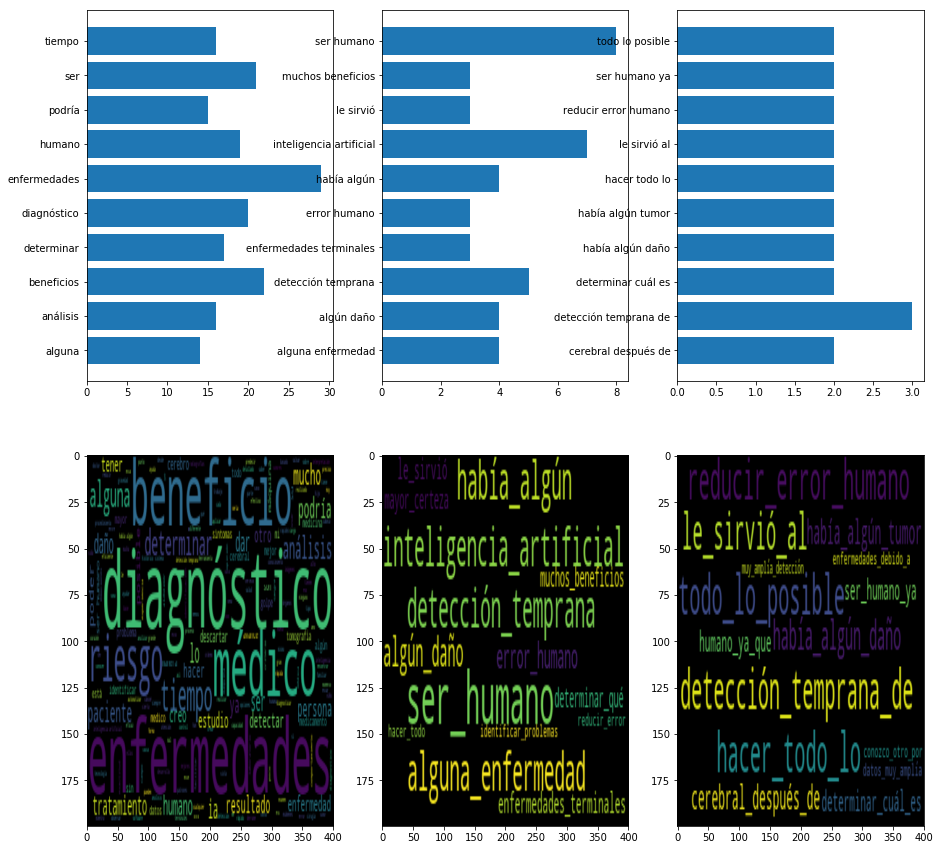

In [16]:
resultado =  analisis_frecuencia_palabras(corpus_global)


Podemos observar algunas cosas interesantes
* "diagnóstico" es predominante, lo cual indica que se cree que la IA puede ser usada para diagnóstico.
* "beneficio" es también predominante, la percepción hacía la IA es mayormente positiva, aun que podemos ver que también esta presente la palabra "riesgo" , se necesita analizar no por palabras si no por n-gramas para ver que palabras acompañan a riesgo, con el objetivo de determinar si en conjunto con otras palabras la muestra expresa que considera que existirá una disminución de riesgo o bien si consieran a la IA riesgosa.
* "enfermedades" es otra palabra predominante ,algo posiblemente de esperarse y posiblemente asociado con "diagnóstico"

## Pregunta 1:  ¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?

### Análisis de frecuencia de palabras

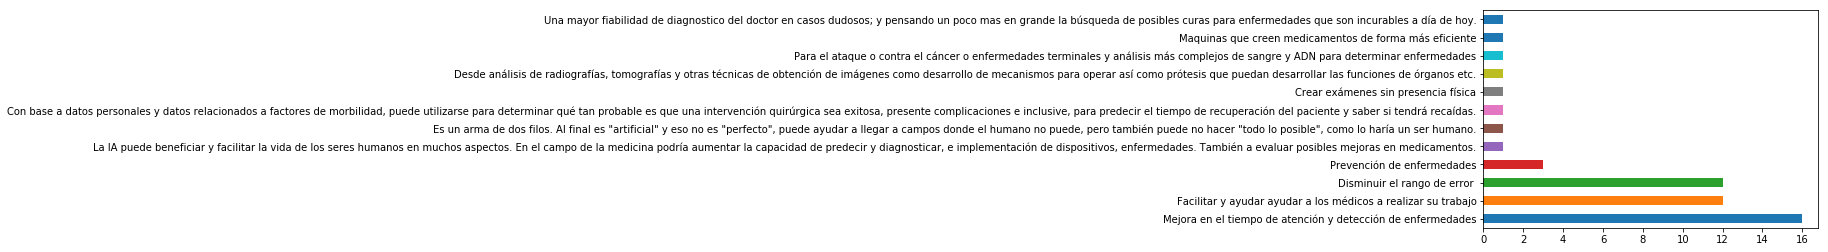

In [44]:
pregunta="¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?"
analisis_categorias(datos_primera_pregunta,pregunta)

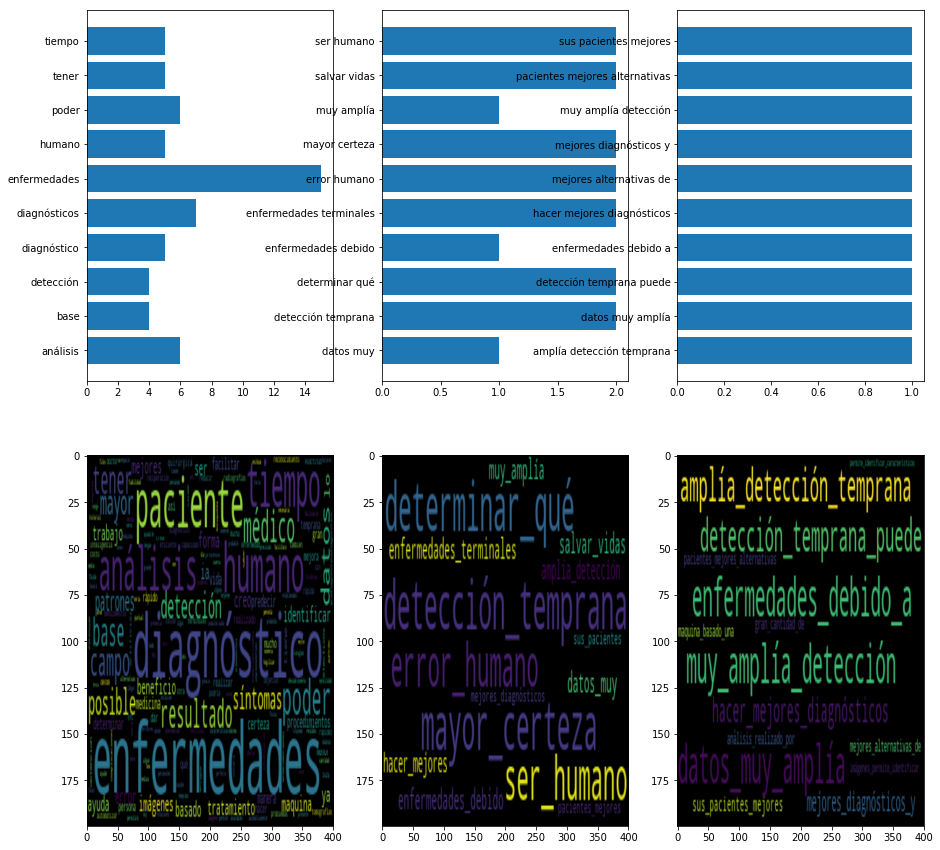

In [17]:
resultados_pregunta1 = datos_originales["¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?"]
pregunta1_corpus = resultados_pregunta1.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta1_corpus)

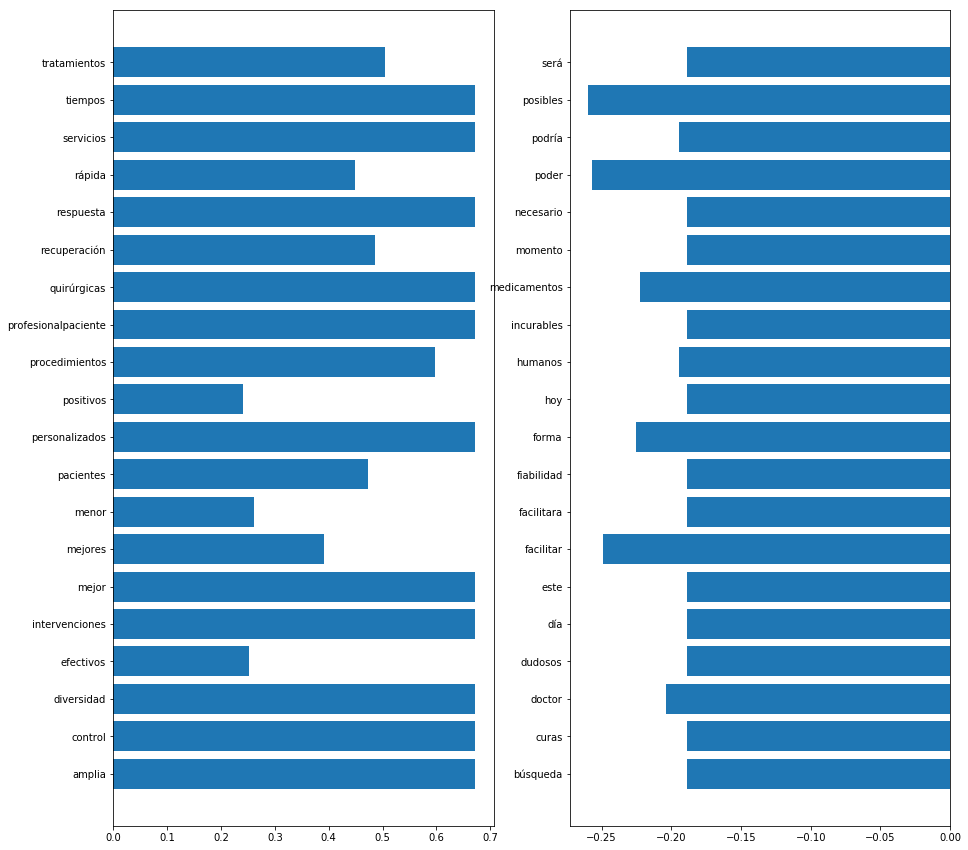

In [18]:
resultados_pregunta1 = datos_originales["¿Qué beneficios cree usted que puede tener esta inteligencia artificial en el campo de la medicina?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)



* Mientras mas aumenta la edad ,mas aumenta la manifestación de cosas como :tiempos,servicios,respuesta,personalizados(diagnosticos) y control. como un beneficio de la IA.
* Mientras mas aumenta la edad, mas disminuye la manifestación de beneficios como "facilitar"  de la IA.

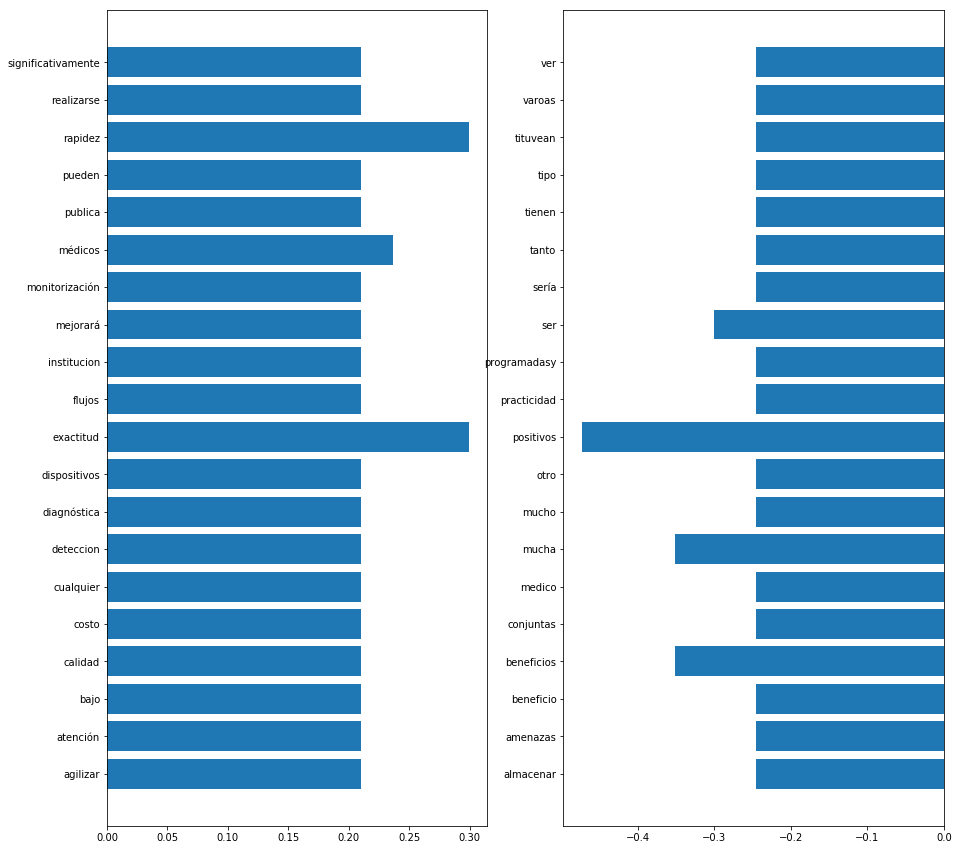

In [19]:
correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales["Nivel Educativo"],vectorizer)

## Pregunta 2:  Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?

### Análisis de frecuencia de palabras

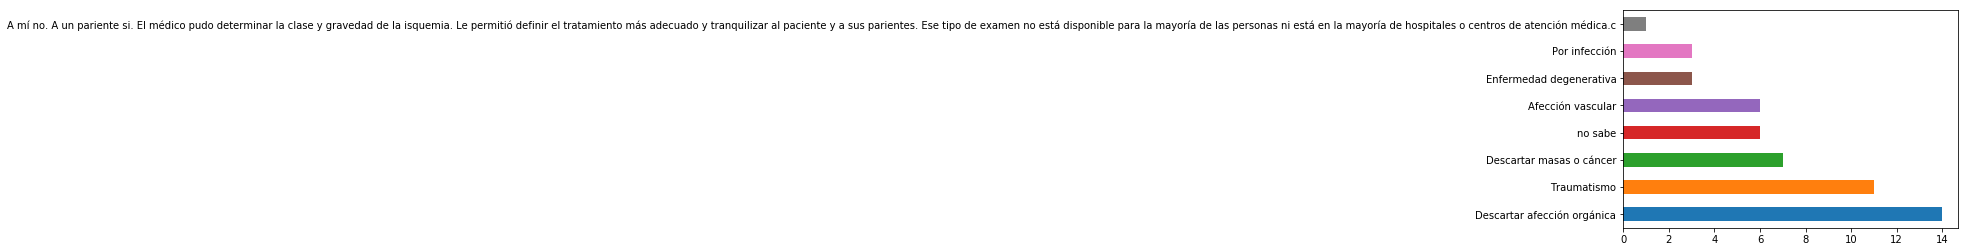

In [48]:
pregunta="Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?"
analisis_categorias(datos_segunda_pregunta,pregunta)

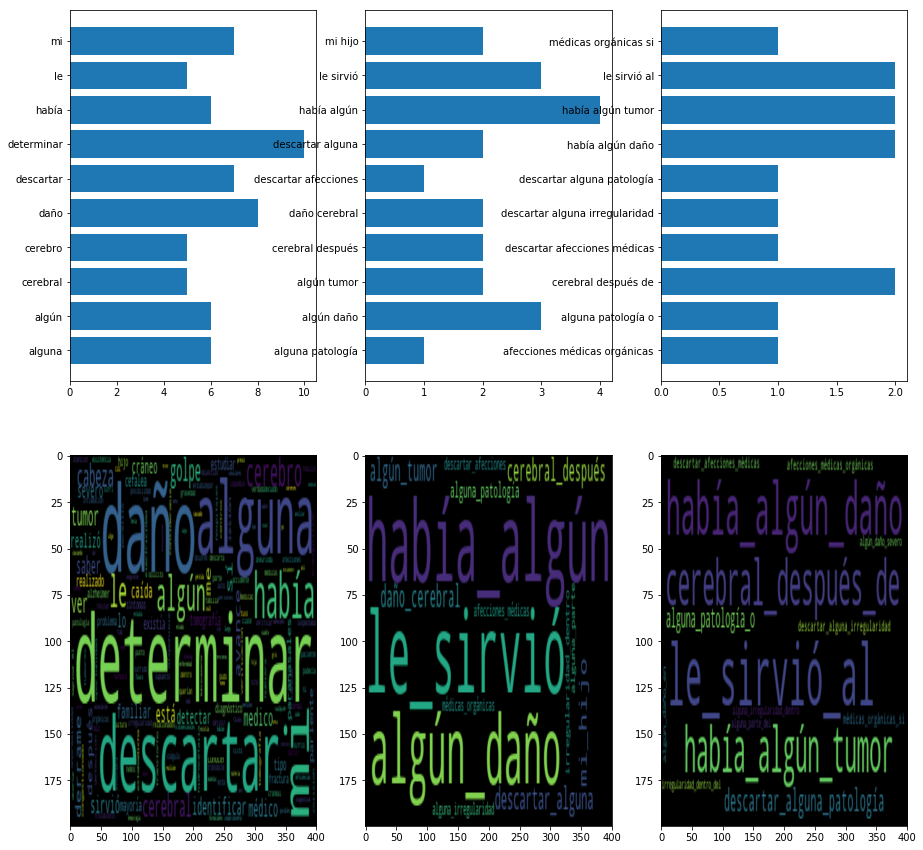

In [20]:
resultados_pregunta2 = datos_originales["Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?"]
pregunta2_corpus = resultados_pregunta2.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta2_corpus)

resultados_pregunta1 = datos_originales["Le han realizado una tomografía de cráneo a usted o a un familiar o conocido cercano, ¿para qué le sirvió a su médico este estudio?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)

## Pregunta 3: ¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?

### Análisis de frecuencia de palabras

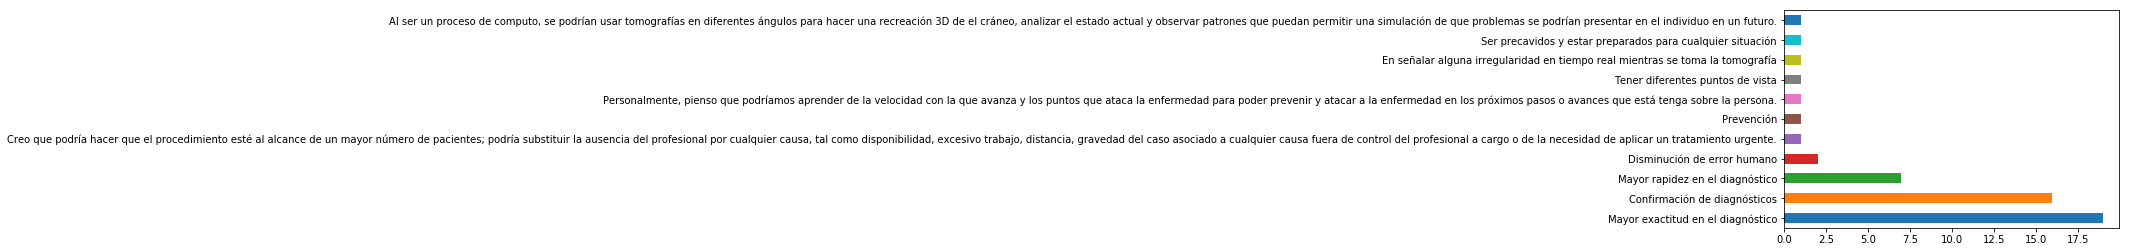

In [49]:
pregunta="3. ¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?"
analisis_categorias(datos_tercera_pregunta,pregunta)

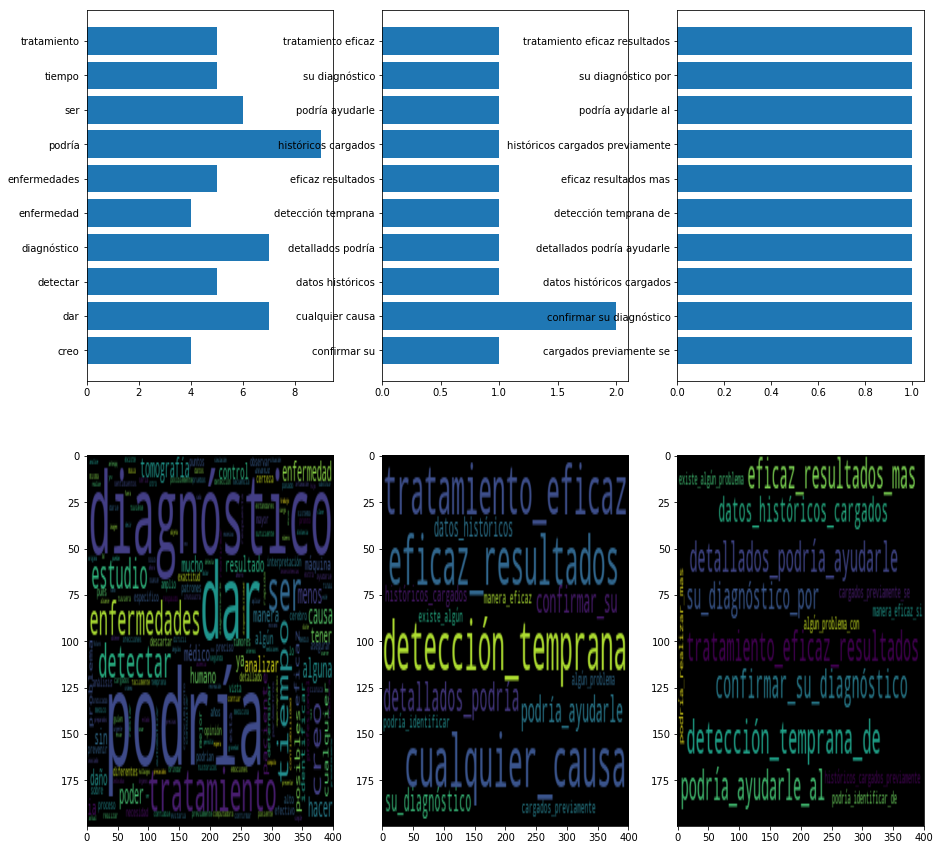

In [21]:
resultados_pregunta3 = datos_originales["¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?"]
pregunta3_corpus = resultados_pregunta3.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta3_corpus)

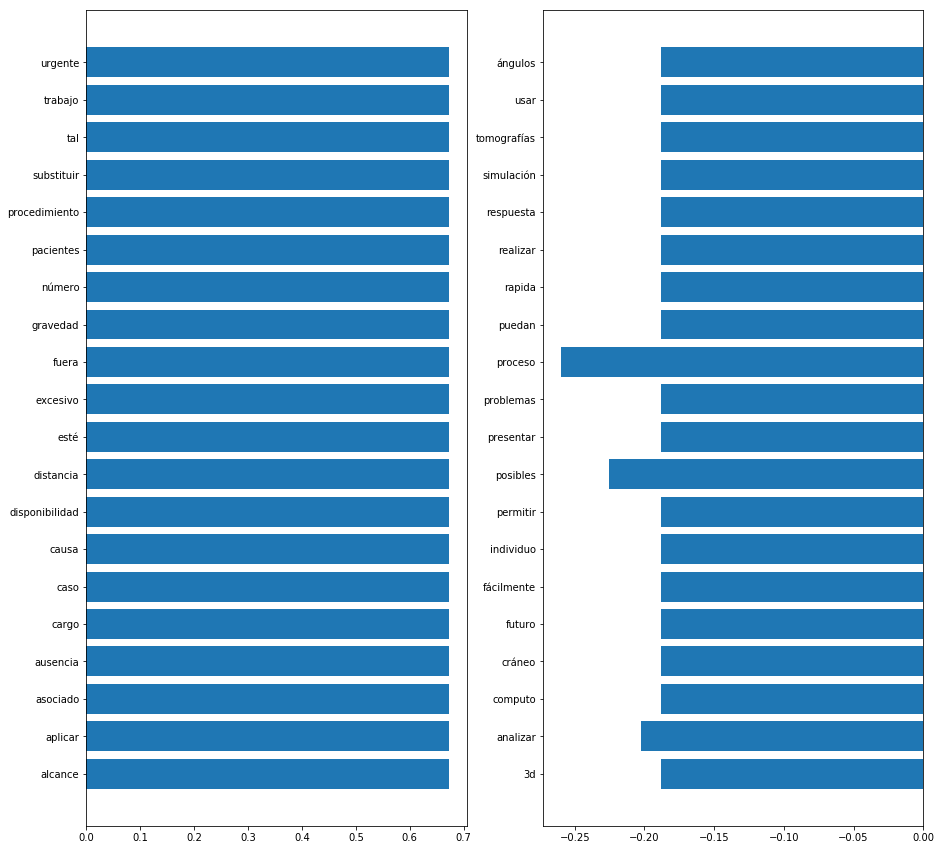

In [22]:
resultados_pregunta1 = datos_originales["¿Qué beneficio cree que pueda tener la inteligencia artificial en el estudio que su médico le solicitó a su familiar?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)

* Hay palabras  altamente correlacionadas con la edad, pero ninguna que sobresalga
* La palabra "proceso" esta correlacionada negativamente con la edad(a mayor edad) menos uso de proceso.

De momento parece que no se  puede concluir por edad.

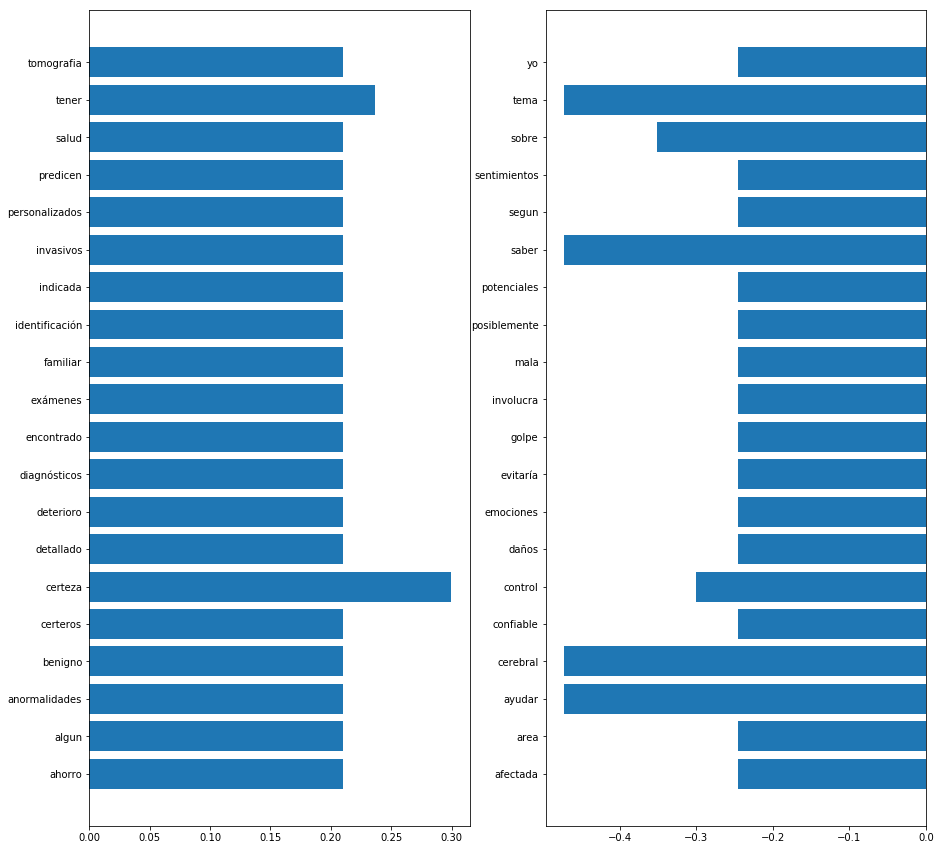

In [24]:
correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales["Nivel Educativo"],vectorizer)

## Pregunta 4: En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?

### Análisis de frecuencia de palabras

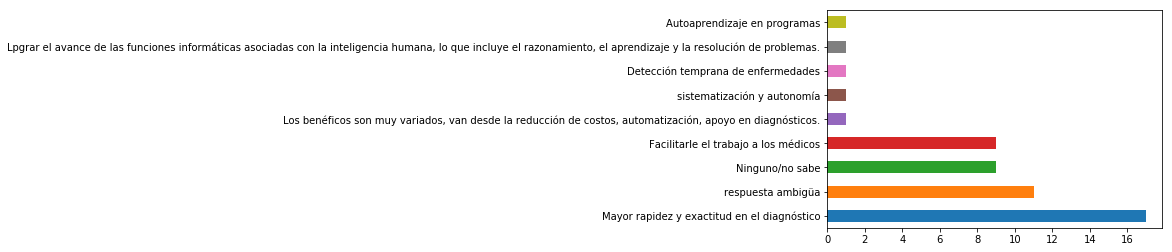

In [50]:
pregunta="4a. En su opinión, ¿qué beneficios puede tener la inteligencia artificial?"
analisis_categorias(datos_cuarta_pregunta,pregunta)

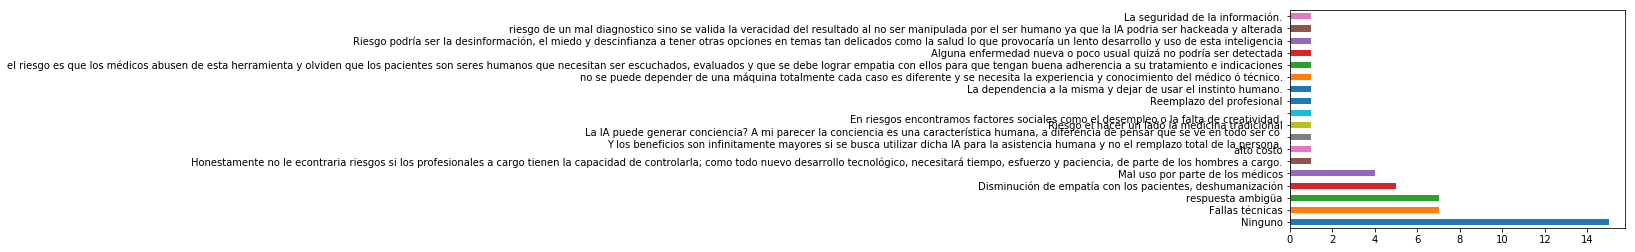

In [51]:
pregunta="4b. En su opinión, ¿qué riesgo puede tener la inteligencia artificial?"
analisis_categorias(datos_cuarta_pregunta,pregunta)

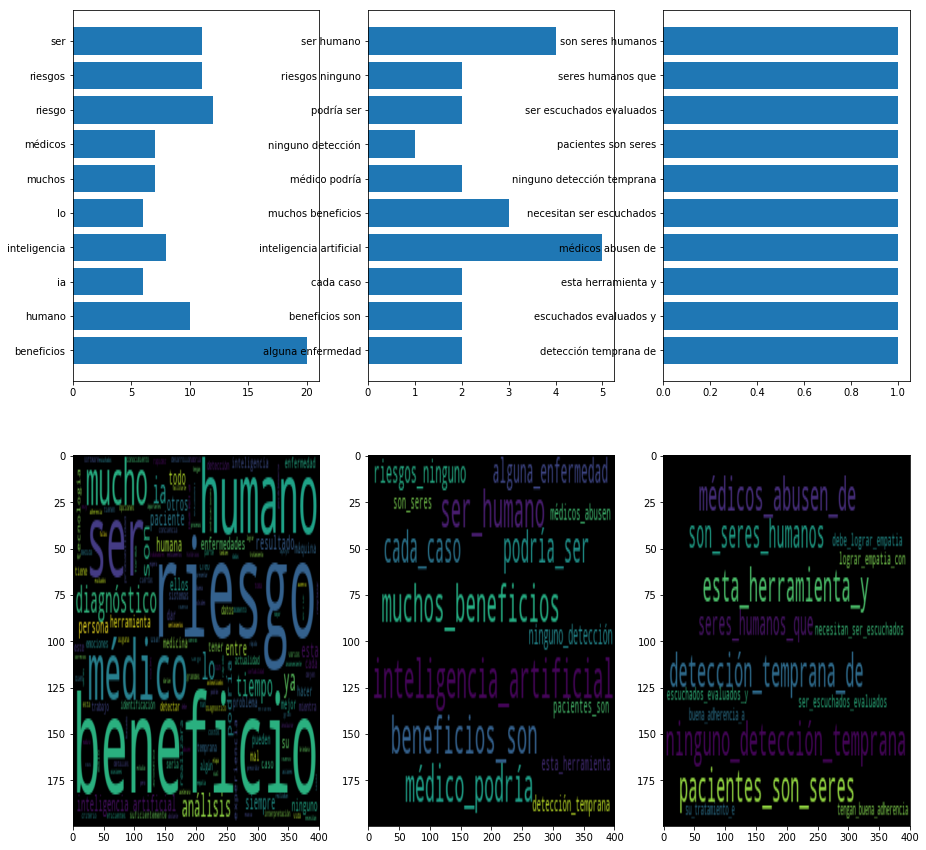

In [25]:
resultados_pregunta3 = datos_originales["En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?"]
pregunta3_corpus = resultados_pregunta3.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta3_corpus)

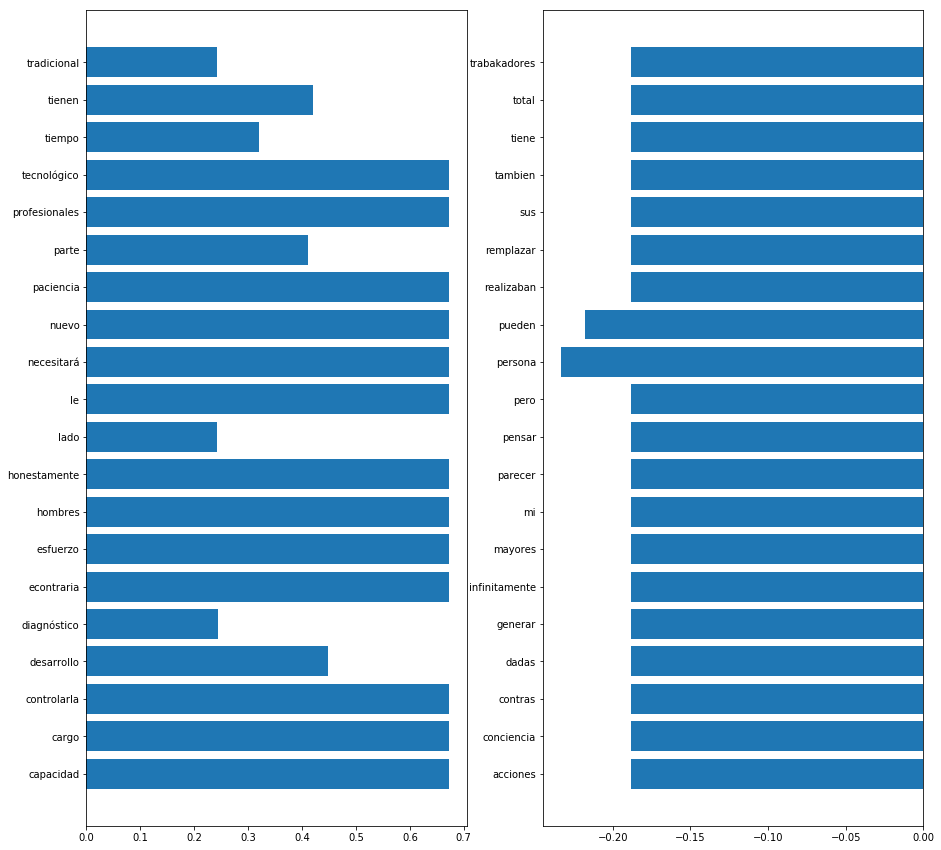

In [26]:
resultados_pregunta1 = datos_originales["En su opinión, ¿qué beneficios o riesgo puede tener la inteligencia artificial?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)

Hay palabras altamente correlacionadas con la edad,pero parecen no aportar información valiosa

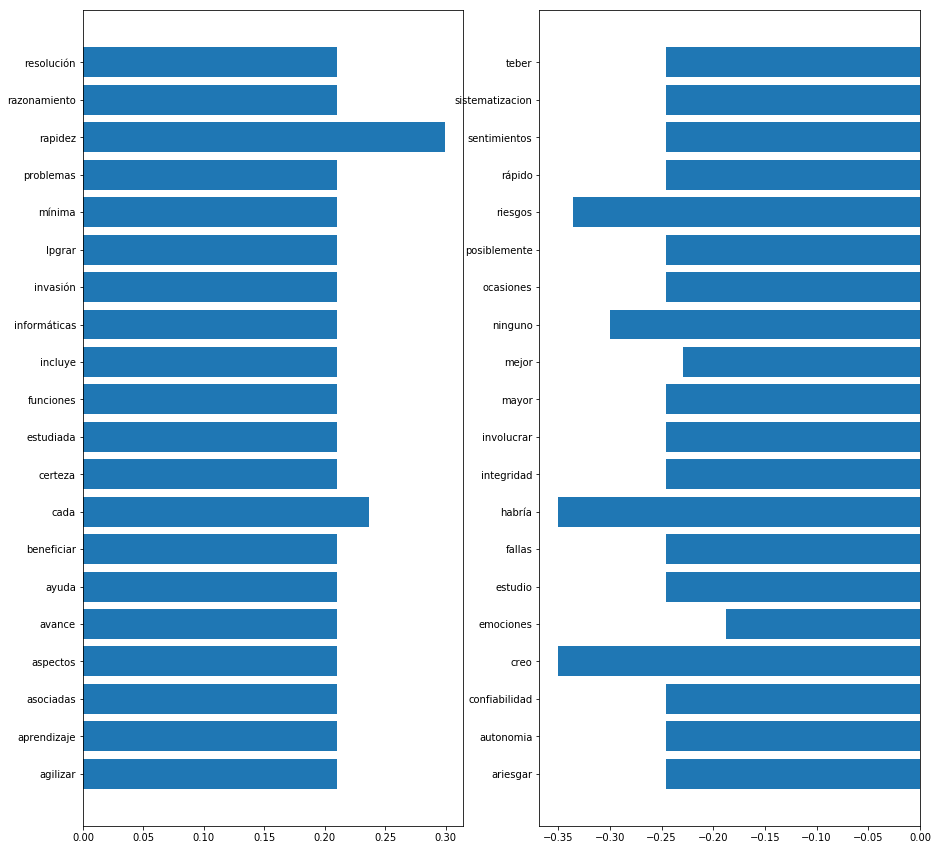

In [27]:
correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales["Nivel Educativo"],vectorizer)

## Pregunta 5: ¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?


### Análisis de frecuencia de palabras

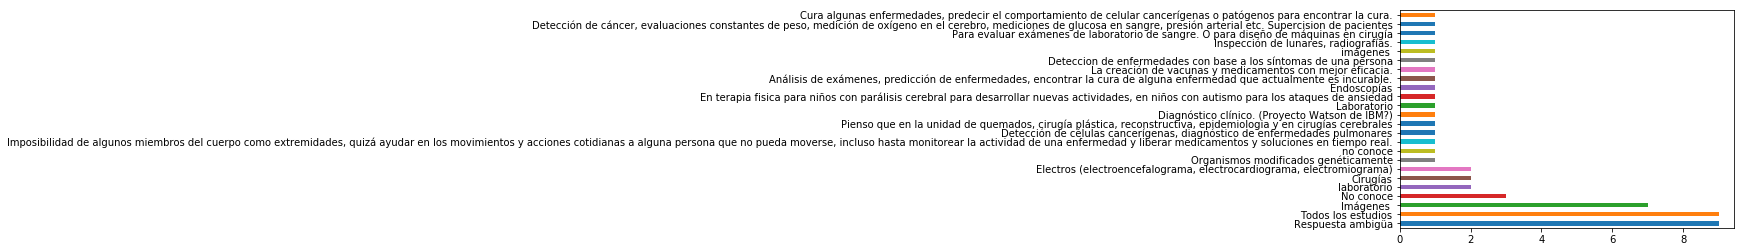

In [52]:
pregunta="5. ¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?"
analisis_categorias(datos_quinta_pregunta,pregunta)

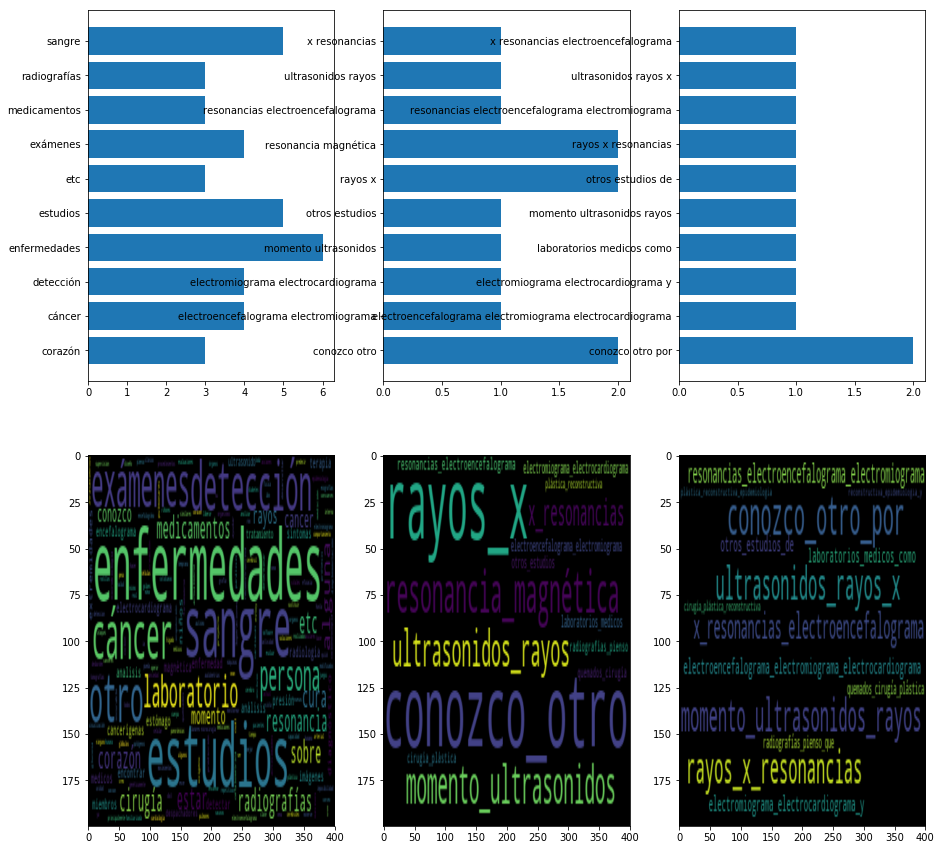

In [28]:
resultados_pregunta4 = datos_originales["¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?"]
pregunta4_corpus = resultados_pregunta4.str.cat(sep=" ")
resultado = analisis_frecuencia_palabras(pregunta4_corpus)

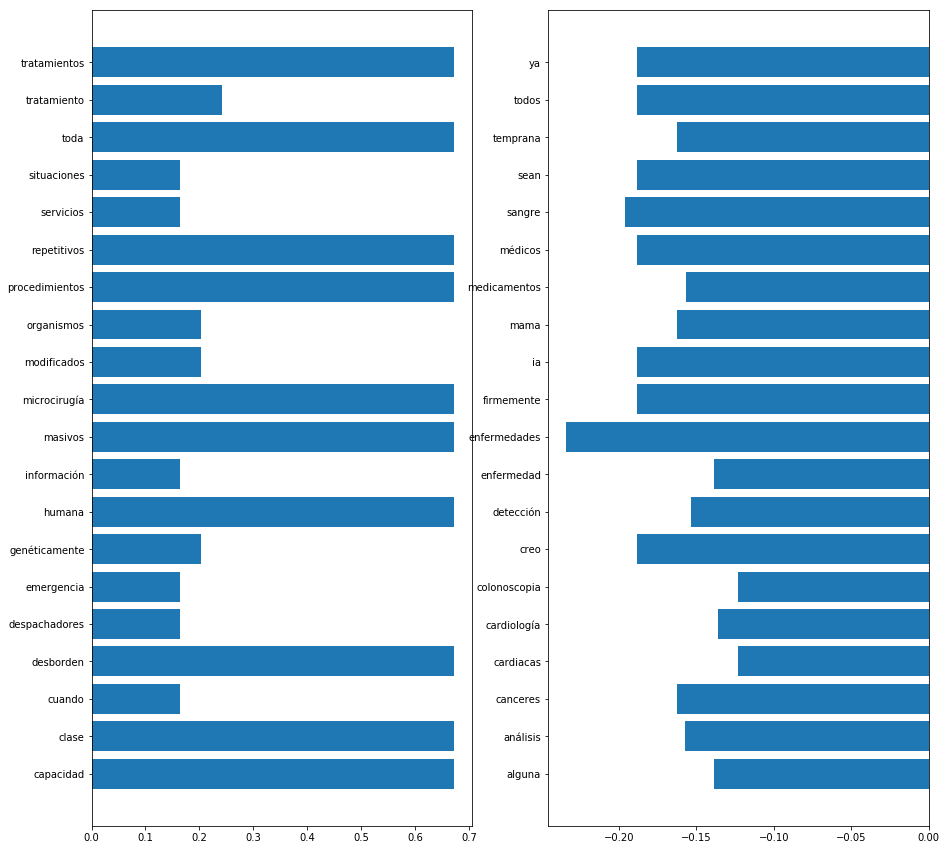

In [29]:
resultados_pregunta1 = datos_originales["¿Qué otros estudios médicos conoce, en los cuales considera que se pueda aplicar la inteligencia artificial?"]
conteos,transformer,vectorizer,tfidf = calc_tf_idf(resultados_pregunta1)

correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales.Edad,vectorizer)

* Hay palabras correlacionadas con la edad, entre ellas destaca "microcirugía" ,conforme avanza la edad se necesitan mas cirugías?
* La palabra "enfermedades"  para disminuir su uso conforme aumenta la edad.

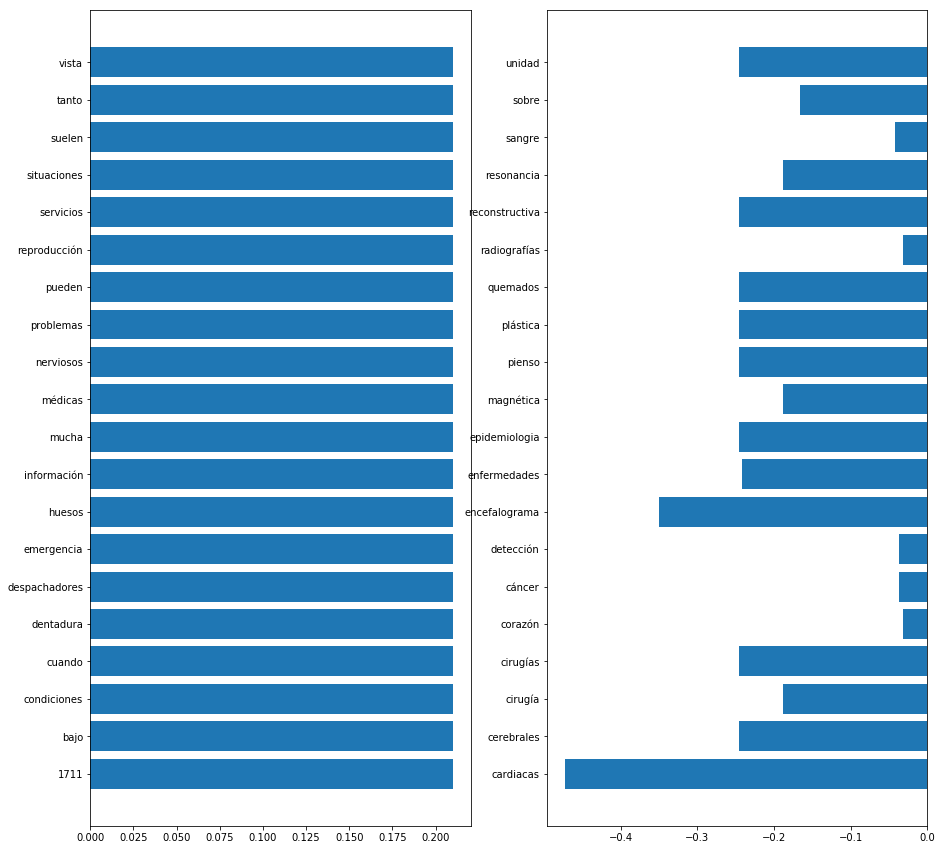

In [30]:
correlacion_pos,correlacion_neg = correlacion_edad_palabras(conteos,datos_originales["Nivel Educativo"],vectorizer)

## Algunos resultados obtenidos del análisis de información.

1. El conocimiento que tiene la población estudiada sobre la aplicación de la IA en medicina es empírico o pragmatico? ** Aunque la mayoría no sabe con exactitud y de manera técnica que es la IA, la mayoría expresa beneficios que esta puede tener,lo cual enmarca el conocimento como prágmatismo. **